In [1]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

%matplotlib inline

C:\Users\issa\AppData\Local\conda\conda\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set a few configuration parameters.
img_height = 480
img_width = 640
n_classes = 20
model_mode = 'inference'

In [3]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7_Instance_epoch-15_loss-2.8123_val_loss-2.4207.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

In [4]:
dataset = DataGenerator()

# TODO: Set the paths to the dataset here.
Pascal_VOC_dataset_images_dir = '../datasets/ICUB_Instance/test'
Pascal_VOC_dataset_annotations_dir = '../datasets/ICUB_Instance/test_ann'
Pascal_VOC_dataset_image_set_filename = '../datasets/ICUB_Instance/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background','book1','book2','book3','book4','book5',
          'cellphone1','cellphone2','cellphone3','cellphone4','cellphone5',
          'mouse1','mouse2','mouse3','mouse4','mouse5',
          'ringbinder1','ringbinder2','ringbinder3','ringbinder4','ringbinder5']
           

dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
                  image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
                  annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'test.txt': 100%|██████████████████████████████████████████████| 396/396 [00:01<00:00, 338.00it/s]


In [8]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=2,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.1,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 396

Producing predictions batch-wise: 100%|██████████████████████████████████████████████| 198/198 [00:48<00:00,  4.10it/s]
Matching predictions to ground truth, class 1/20.: 100%|████████████████████████| 2749/2749 [00:00<00:00, 26811.85it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████████████████████| 349/349 [00:00<00:00, 21873.41it/s]
Matching predictions to ground truth, class 3/20.: 100%|████████████████████████| 3075/3075 [00:00<00:00, 25743.17it/s]
Matching predictions to ground truth, class 4/20.: 100%|████████████████████████| 1429/1429 [00:00<00:00, 19611.35it/s]
Matching predictions to ground truth, class 5/20.: 100%|████████████████████████| 2950/2950 [00:00<00:00, 34776.20it/s]
Matching predictions to ground truth, class 6/20.: 100%|████████████████████████| 2033/2033 [00:00<00:00, 31360.52it/s]
Matching predictions to ground truth, class 7/20.: 100%|████████████████████████| 1148/1148 [00:00<00:00, 34881

In [10]:
import numpy as np
np.savez('Test_Results/SSD7_20_Instance.npz', mean_average_precision=mean_average_precision, average_precisions=average_precisions,precisions=precisions,recalls=recalls)

In [5]:
import numpy as np
data = np.load('Test_Results/SSD7_20_Instance.npz')
mean_average_precision = data['mean_average_precision']
average_precisions = data['average_precisions']
precisions = data['precisions']
recalls = data['recalls']

In [7]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', mean_average_precision, 3))

book1         AP    0.593
book2         AP    0.352
book3         AP    0.33
book4         AP    0.773
book5         AP    0.74
cellphone1    AP    0.414
cellphone2    AP    0.222
cellphone3    AP    0.536
cellphone4    AP    0.126
cellphone5    AP    0.476
mouse1        AP    0.551
mouse2        AP    0.621
mouse3        AP    0.557
mouse4        AP    0.47
mouse5        AP    0.589
ringbinder1   AP    0.236
ringbinder2   AP    0.092
ringbinder3   AP    0.173
ringbinder4   AP    0.182
ringbinder5   AP    0.227

              mAP   0.41307045597920994


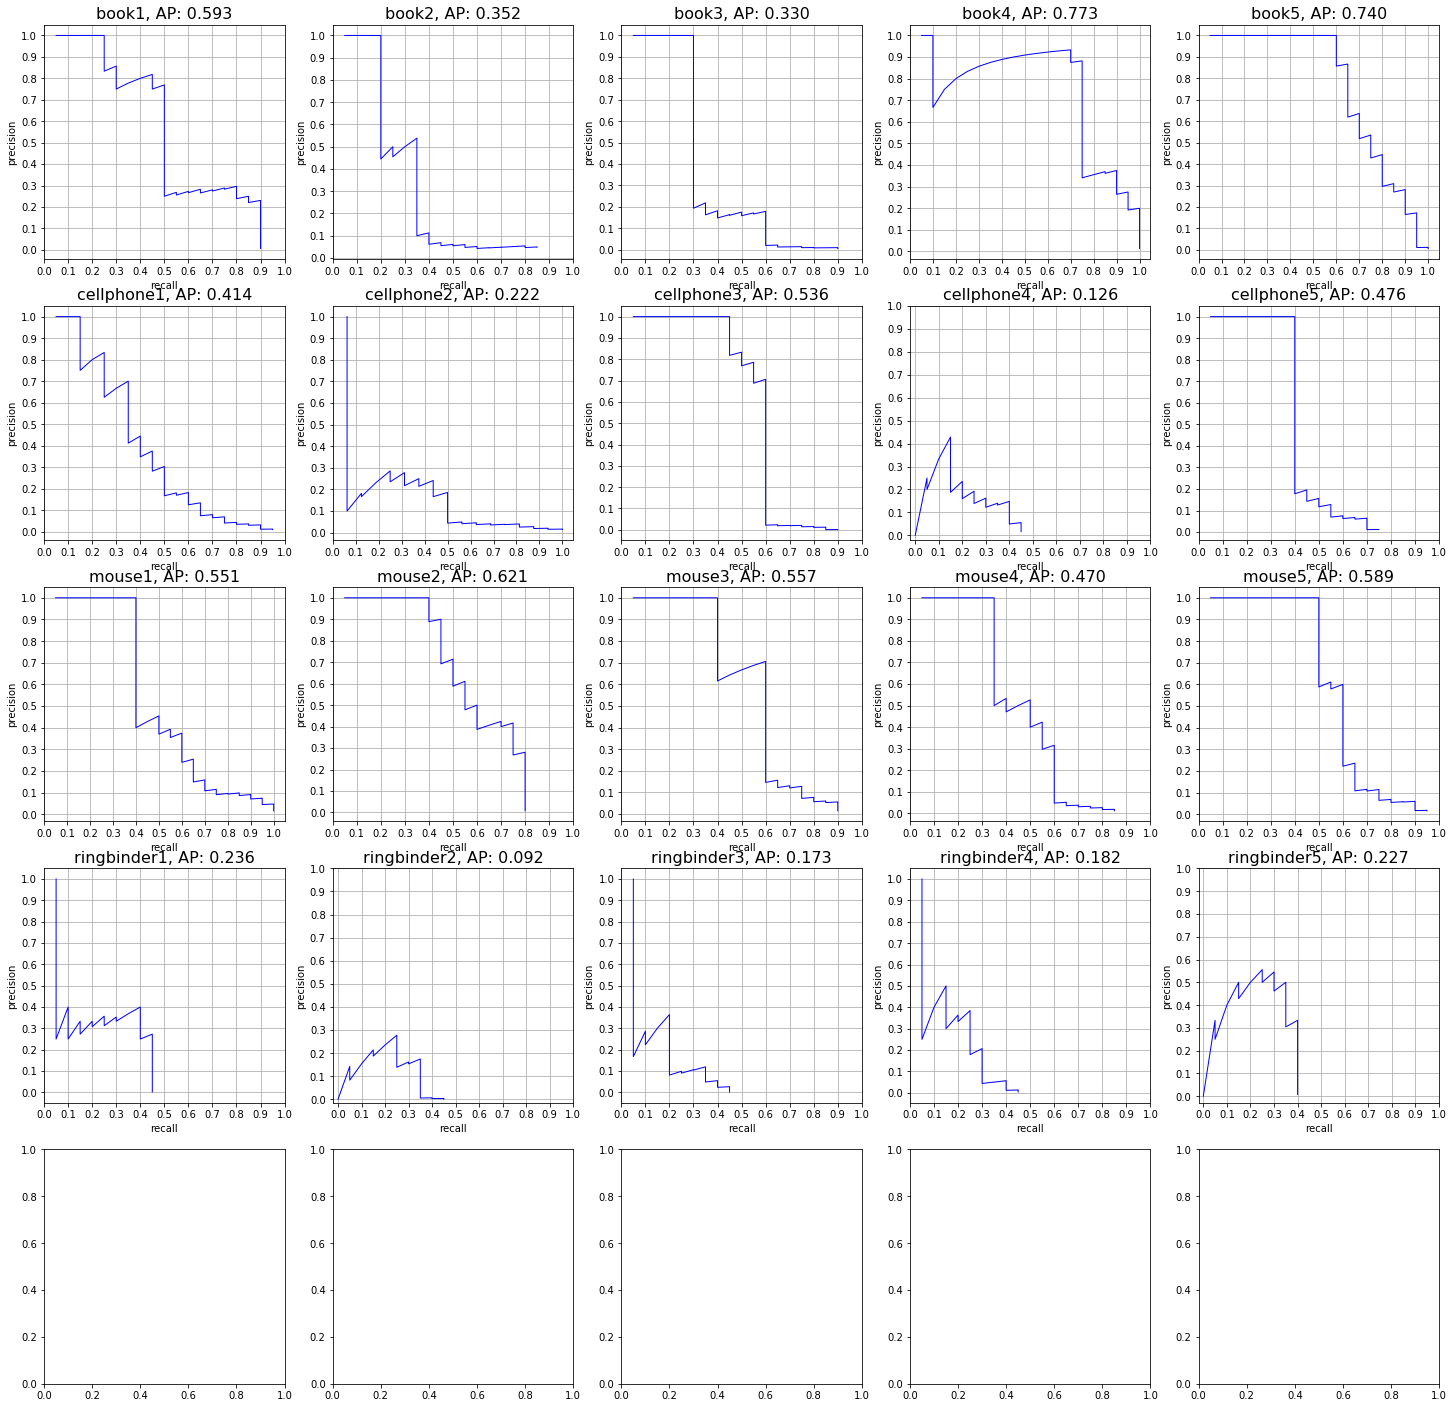

In [13]:
m = max((n_classes + 1) // 5, 5)
n = 5

fig, cells = plt.subplots(m, n, figsize=(n*5,m*5))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=10)
        cells[i, j].set_ylabel('precision', fontsize=10)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

In [9]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

Matching predictions to ground truth, class 4/4.: 100%|███████████████████████| 12573/12573 [00:00<00:00, 29476.31it/s]
Computing precisions and recalls, class 1/4
5
Computing precisions and recalls, class 2/4
5
Computing precisions and recalls, class 3/4
5
Computing precisions and recalls, class 4/4
5
Computing average precision, class 1/4
Computing average precision, class 2/4
Computing average precision, class 3/4
Computing average precision, class 4/4


In [10]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

book          AP    0.338
cellphone     AP    0.45
mouse         AP    0.936
ringbinder    AP    0.059

              mAP   0.446


In [7]:
evaluator??